In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
from jax import jit

import qdots_qll.all_funcs as all_f
from qdots_qll.process_representations import *
from qdots_qll.all_funcs import *
import joblib

from importlib import reload
import matplotlib.pyplot as plt



In [2]:
import h5py


def import_hdf5(filename):
    f = h5py.File(filename, "r")
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    return np.array(data)


arr = import_hdf5("numerical_L_true_mathematica.hdf5")

true_L = arr["Re"] + 1j * arr["Im"]

In [3]:
N = 2
G = np.array(
    [qu.identity(N), qu.sigmax(), qu.sigmay(), qu.sigmaz()]
) / np.sqrt(N)

In [4]:
mat_gg = all_f.make_diss_gjgi(G, N)

In [51]:
measurement_ops = []

for i in [qu.sigmax().full(), qu.sigmay().full(), qu.sigmaz().full()]:
    measurement_ops.append(
        (vec(0.5 * (np.identity(2) + i)), vec(0.5 * (np.identity(2) - i)))
    )

measurement_ops = jnp.array(measurement_ops)
measurement_ops = measurement_ops[0, 0]

In [6]:

measurement_ops

Array([[1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]], dtype=complex64)

In [7]:
# Basic model

delta = 0.12739334807998307
Omega = 0.5

A = np.array([[1, 0], [0, 0]])
sigmap = np.array([[0, 1], [0, 0]])
sigman = np.array([[0, 0], [1, 0]])

H0 = delta * A + Omega / 2 * (sigmap + sigman)

measurement_ops = vec(np.array([[1, 0], [0, 0]]))

true_vals = joblib.load("true_vals.job")

rho0 = vec(np.array([[1, 0], [0, 0]]))

bnds = jnp.array([[-0.2, 0.2],
                  [-1, 1],
                  [-0.1, 0.1],
                  [-0.2, 0.2],
                  [-0.2, 0.2],
                  [-0.2, 0.2],
                  [-0.2, 0.2],
                  [-0.2, 0.2]
                  ])

In [8]:
phys_model = {
    "Dim of H space": d,
    "H": H0,
    "True Lindbladian": true_L,
    "Measurement operators": measurement_ops,
    "Initial state": rho0,
    "Identity matrix vectorized": vec(jnp.eye(d)),
    "Identity matrix": jnp.eye(d),
    "Mat_gg": mat_gg,
}

model = {
    "Number of parameters": 8,
    "Space boundaries": bnds,  #jnp.array([[-1, 1] for _ in range(8)]),
    "Number of particles": 500,
    "Number of experimental repetitions": 5,
    "physical_model": phys_model,
}

In [9]:
compute_p(rho0, measurement_ops)

Array(1., dtype=float32, weak_type=True)

In [22]:

key = jax.random.PRNGKey(seed=0)
weights = all_f.initialize_weights(model["Number of particles"])
key, particles_locations = initialize_particle_locations(key, model)
cov = []
iter = 0

In [59]:


for _ in range(30):
    iter = iter+1
    print(f"Iteration number: {iter}")
    key, subkey = jax.random.split(key)
    t = jax.random.uniform(key=subkey, minval=0.01, maxval=100)

    keys = jax.random.split(
        key, model["Number of experimental repetitions"] + 1
    )

    key = keys[0]
    _, results = jax.jit(jax.vmap(generate_data, (0, None, None, None)))(
        keys[1:], measurement_ops, t, model["physical_model"]
    )

    lkl = compute_likelihood_data(
        results, particles_locations, measurement_ops, t, model["physical_model"]
    )

    weights = update_weights(lkl, weights)
    cov.append(est_cov(particles_locations, weights))

    if ESS(weights) <= 0.5 * particles_locations.shape[1]:
        print("Resampling...")
        key, particles_locations, weights = resample_now(key, particles_locations, weights)

cov_arr = jnp.array(cov)

Iteration number: 271
Iteration number: 272
Iteration number: 273
Iteration number: 274
Iteration number: 275
Iteration number: 276
Iteration number: 277
Iteration number: 278
Iteration number: 279
Iteration number: 280
Iteration number: 281
Iteration number: 282
Iteration number: 283
Iteration number: 284
Iteration number: 285
Iteration number: 286
Iteration number: 287
Iteration number: 288
Iteration number: 289
Iteration number: 290
Iteration number: 291
Iteration number: 292
Iteration number: 293
Iteration number: 294
Iteration number: 295
Iteration number: 296
Iteration number: 297
Iteration number: 298
Iteration number: 299
Iteration number: 300


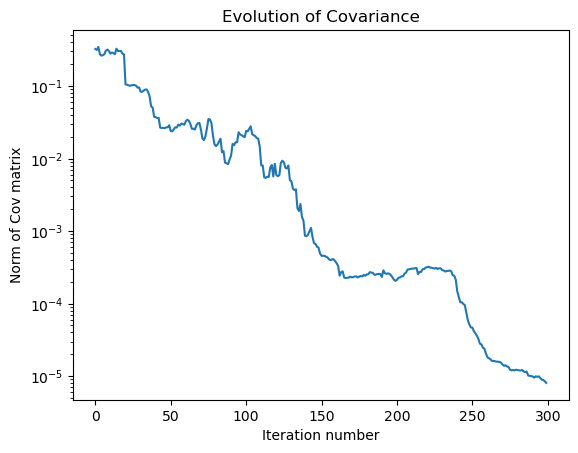

In [60]:
plt.title("Evolution of Covariance")
plt.plot(jax.vmap(jnp.linalg.norm, in_axes=(0))(cov_arr))
plt.xlabel("Iteration number")
plt.ylabel("Norm of Cov matrix")
plt.yscale('log')
plt.show()

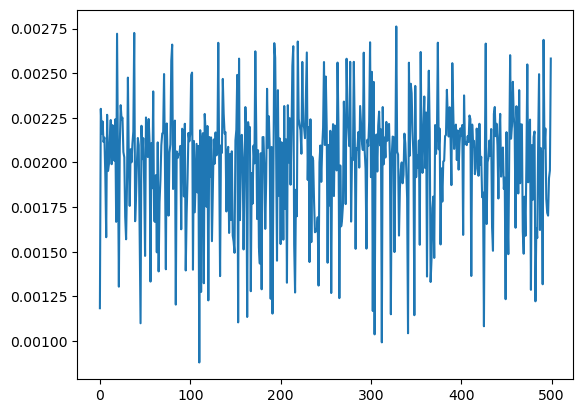

In [40]:
plt.plot(weights)

In [61]:
jnp.diag((est_cov(particles_locations, weights)))

Array([1.4236430e-06, 1.5209080e-06, 2.3730099e-06, 2.5331974e-06,
       1.3201497e-07, 2.9262155e-06, 1.9255094e-07, 2.9336661e-07],      dtype=float32)

In [63]:
est_mean(particles_locations, weights).T

Array([-0.04111717, -0.01775995, -0.11498529, -0.19902107,  0.0565663 ,
       -0.13607489,  0.06095237,  0.1083001 ], dtype=float32)

In [62]:
true_vals

array([-0.127393  , -0.489548  ,  0.000723  , -0.0014456 , -0.00149873,
       -0.02090308,  0.00267172,  0.01134756], dtype=float32)

In [57]:
to_chi_from_super(true_L).round(3)

array([[-0.011+0.j   , -0.003-0.479j, -0.001-0.001j,  0.   -0.j   ],
       [-0.003+0.479j,  0.   +0.j   ,  0.   +0.j   , -0.001-0.001j],
       [-0.001+0.001j,  0.   +0.j   ,  0.   +0.j   , -0.021+0.003j],
       [ 0.   +0.j   , -0.001+0.001j, -0.021-0.003j,  0.011+0.j   ]],
      dtype=complex64)

In [66]:
(generate_liouvillian_particle(est_mean(particles_locations, weights), phys_model)).round(3)

Array([[ 0.        +0.j        , -0.21400002-0.164j     ,
        -0.21400002+0.164j     ,  0.        +0.j        ],
       [-0.045     -0.24400002j, -0.108     +0.086j     ,
         0.        +0.j        , -0.07600001+0.35700002j],
       [-0.045     +0.24400002j,  0.        +0.j        ,
        -0.108     -0.086j     , -0.07600001-0.35700002j],
       [ 0.        +0.j        ,  0.21400002+0.164j     ,
         0.21400002-0.164j     ,  0.        +0.j        ]],      dtype=complex64)

In [44]:
to_chi_from_super(generate_liouvillian_particle(particles_locations[jnp.argmax(weights)], phys_model)).round(3)

array([[-0.093+0.j   , -0.078+0.481j,  0.066+0.238j,  0.   +0.059j],
       [-0.078-0.481j,  0.   +0.j   ,  0.   +0.j   , -0.218+0.066j],
       [ 0.066-0.238j,  0.   +0.j   ,  0.   +0.j   , -0.155+0.078j],
       [ 0.   -0.059j, -0.218-0.066j, -0.155-0.078j,  0.093+0.j   ]],
      dtype=complex64)